Using device: cuda


100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


[MLP] Trainable parameters: 1,738,890
[MLP] Approx model size: 6.96 MB (float32)
Epoch [1/70] | Train Loss: 1.7942 | Train Acc: 35.98% | Val Loss: 1.5882 | Val Acc: 43.77%
Epoch [2/70] | Train Loss: 1.6416 | Train Acc: 42.13% | Val Loss: 1.5236 | Val Acc: 45.81%
Epoch [3/70] | Train Loss: 1.5667 | Train Acc: 44.80% | Val Loss: 1.4863 | Val Acc: 47.27%
Epoch [4/70] | Train Loss: 1.5216 | Train Acc: 46.32% | Val Loss: 1.4410 | Val Acc: 48.16%
Epoch [5/70] | Train Loss: 1.4879 | Train Acc: 47.56% | Val Loss: 1.4248 | Val Acc: 49.40%
Epoch [6/70] | Train Loss: 1.4519 | Train Acc: 48.71% | Val Loss: 1.4104 | Val Acc: 49.95%
Epoch [7/70] | Train Loss: 1.4255 | Train Acc: 49.85% | Val Loss: 1.3950 | Val Acc: 51.35%
Epoch [8/70] | Train Loss: 1.4067 | Train Acc: 50.44% | Val Loss: 1.3914 | Val Acc: 51.33%
Epoch [9/70] | Train Loss: 1.3789 | Train Acc: 51.51% | Val Loss: 1.3633 | Val Acc: 51.83%
Epoch [10/70] | Train Loss: 1.3552 | Train Acc: 52.18% | Val Loss: 1.3684 | Val Acc: 52.29%
Epoch [1

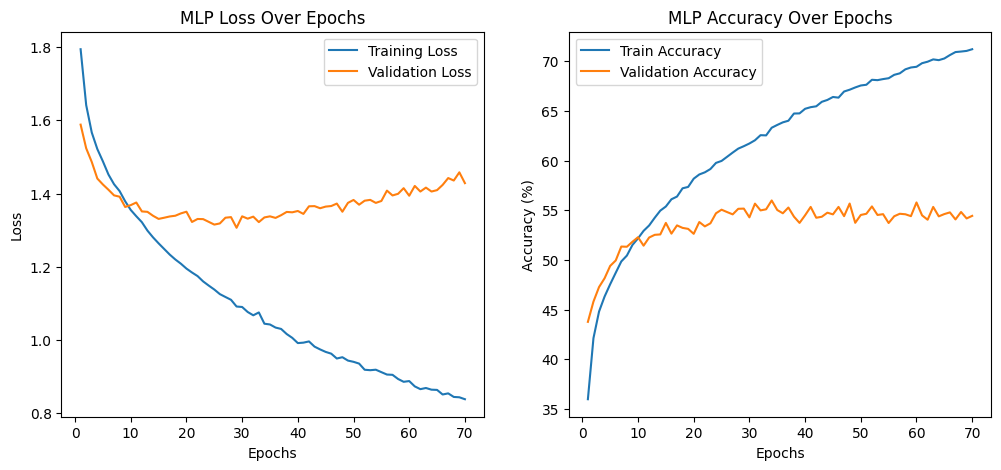


Classification Report:
              precision    recall  f1-score   support

           0     0.5810    0.6530    0.6149      1000
           1     0.7562    0.5770    0.6546      1000
           2     0.4428    0.4220    0.4322      1000
           3     0.3490    0.4820    0.4049      1000
           4     0.4579    0.4730    0.4653      1000
           5     0.4730    0.3510    0.4030      1000
           6     0.5980    0.5980    0.5980      1000
           7     0.6820    0.5620    0.6162      1000
           8     0.5969    0.7240    0.6543      1000
           9     0.6225    0.6020    0.6121      1000

    accuracy                         0.5444     10000
   macro avg     0.5559    0.5444    0.5455     10000
weighted avg     0.5559    0.5444    0.5455     10000



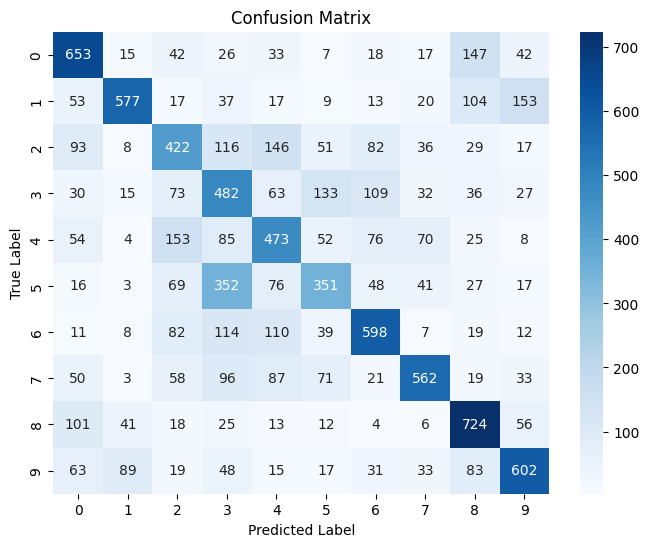

In [ ]:
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
def train_model(model, train_loader, test_loader, epochs=20, pth_path=None, optimizer=None):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_loss, val_acc = evaluate_model(model, test_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if pth_path is not None:
        torch.save(model.state_dict(), pth_path)
    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model(model, test_loader):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy


def plot_results(train_losses, train_accuracies, val_losses, val_accuracies, title_prefix=""):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title_prefix} Accuracy Over Epochs")
    plt.legend()

    plt.show()


def classification_metrics(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
class MLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[512, 256, 128], num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


mlp_model = MLP().to(device)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_params = count_parameters(mlp_model)
print(f"[MLP] Trainable parameters: {mlp_params:,}")
print(f"[MLP] Approx model size: {mlp_params*4/1e6:.2f} MB (float32)")

start_time_mlp = time.time()
mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies = train_model(
    mlp_model,
    train_loader,
    test_loader,
    epochs=70,
    pth_path="baseline_MLP_CIFAR.pth",
    optimizer=mlp_optimizer
)
mlp_train_time = time.time() - start_time_mlp

print(f"[MLP] Training time for 20 epochs: {mlp_train_time/60:.2f} minutes")
print(f"[MLP] Final train loss: {mlp_train_losses[-1]:.4f}")
print(f"[MLP] Final val accuracy: {mlp_val_accuracies[-1]:.2f}%")

plot_results(mlp_train_losses, mlp_train_accuracies, mlp_val_losses, mlp_val_accuracies, title_prefix="MLP")
classification_metrics(mlp_model, test_loader)


[CNN (NetWidth)] Trainable parameters: 38,650
[CNN (NetWidth)] Approx model size: 0.15 MB (float32)
Epoch [1/300] | Train Loss: 1.8903 | Train Acc: 34.36% | Val Loss: 1.6955 | Val Acc: 41.02%
Epoch [2/300] | Train Loss: 1.6313 | Train Acc: 43.27% | Val Loss: 1.5582 | Val Acc: 45.91%
Epoch [3/300] | Train Loss: 1.5252 | Train Acc: 46.96% | Val Loss: 1.4761 | Val Acc: 48.50%
Epoch [4/300] | Train Loss: 1.4517 | Train Acc: 49.63% | Val Loss: 1.4145 | Val Acc: 51.02%
Epoch [5/300] | Train Loss: 1.3864 | Train Acc: 51.83% | Val Loss: 1.3550 | Val Acc: 52.86%
Epoch [6/300] | Train Loss: 1.3259 | Train Acc: 54.17% | Val Loss: 1.2993 | Val Acc: 54.75%
Epoch [7/300] | Train Loss: 1.2726 | Train Acc: 55.68% | Val Loss: 1.2550 | Val Acc: 56.14%
Epoch [8/300] | Train Loss: 1.2295 | Train Acc: 57.34% | Val Loss: 1.2249 | Val Acc: 57.43%
Epoch [9/300] | Train Loss: 1.1973 | Train Acc: 58.35% | Val Loss: 1.1962 | Val Acc: 58.50%
Epoch [10/300] | Train Loss: 1.1682 | Train Acc: 59.32% | Val Loss: 1.17

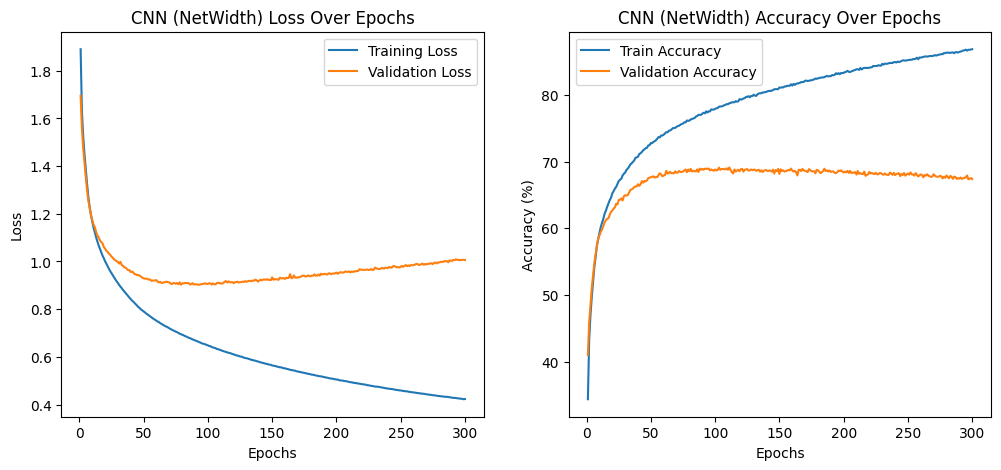


Classification Report:
              precision    recall  f1-score   support

           0     0.7076    0.7260    0.7167      1000
           1     0.7739    0.7940    0.7838      1000
           2     0.5663    0.5040    0.5333      1000
           3     0.4725    0.4810    0.4767      1000
           4     0.6645    0.6160    0.6393      1000
           5     0.5304    0.5850    0.5563      1000
           6     0.7500    0.7650    0.7574      1000
           7     0.7079    0.7490    0.7279      1000
           8     0.8098    0.7750    0.7920      1000
           9     0.7651    0.7460    0.7554      1000

    accuracy                         0.6741     10000
   macro avg     0.6748    0.6741    0.6739     10000
weighted avg     0.6748    0.6741    0.6739     10000



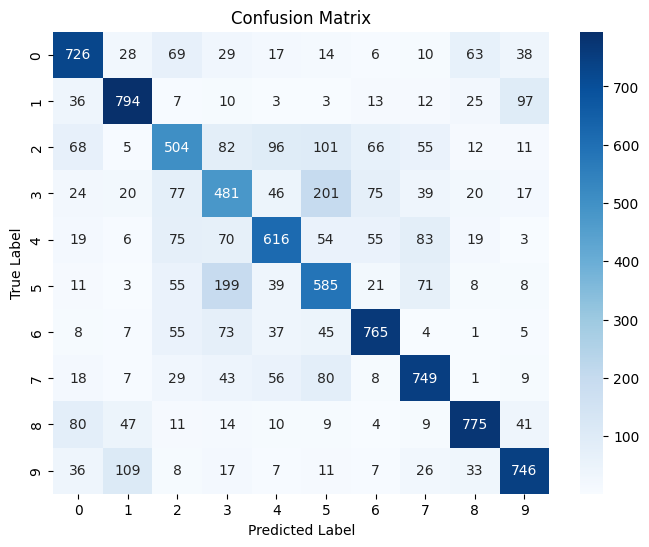

========== SUMMARY ==========
MLP params        : 1,738,890
MLP train time    : 17.11 minutes (70 epochs)
MLP final val acc : 54.44%
-----------------------------
CNN (NetWidth) params     : 38,650
CNN (NetWidth) train time : 76.28 minutes (300 epochs)
CNN (NetWidth) final val acc : 67.41%


In [ ]:
import torch.nn.functional as F
class NetWidthCIFAR10(nn.Module):
    """
    Lecture architecture:

    conv1: 3 -> 32, kernel_size=3, padding=1
    conv2: 32 -> 16, kernel_size=3, padding=1
    max-pool after each conv, tanh activation
    fc1: 16 * 8 * 8 -> 32
    fc2: 32 -> 10 (CIFAR-10 classes)
    """
    def __init__(self, num_classes=10):
        super(NetWidthCIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


cnn_model = NetWidthCIFAR10(num_classes=10).to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-3)

cnn_params = count_parameters(cnn_model)
print(f"[CNN (NetWidth)] Trainable parameters: {cnn_params:,}")
print(f"[CNN (NetWidth)] Approx model size: {cnn_params*4/1e6:.2f} MB (float32)")

EPOCHS_CNN = 300

start_time_cnn = time.time()
cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = train_model(
    cnn_model,
    train_loader,
    test_loader,
    epochs=EPOCHS_CNN,
    pth_path="cnn_NetWidth_CIFAR10_300epochs.pth",
    optimizer=cnn_optimizer
)
cnn_train_time = time.time() - start_time_cnn

print(f"[CNN (NetWidth)] Training time for {EPOCHS_CNN} epochs: {cnn_train_time/60:.2f} minutes")
print(f"[CNN (NetWidth)] Final train loss: {cnn_train_losses[-1]:.4f}")
print(f"[CNN (NetWidth)] Final val accuracy: {cnn_val_accuracies[-1]:.2f}%")

plot_results(cnn_train_losses, cnn_train_accuracies,
             cnn_val_losses, cnn_val_accuracies, title_prefix="CNN (NetWidth)")
classification_metrics(cnn_model, test_loader)


print("========== SUMMARY ==========")
print(f"MLP params        : {mlp_params:,}")
print(f"MLP train time    : {mlp_train_time/60:.2f} minutes (70 epochs)")
print(f"MLP final val acc : {mlp_val_accuracies[-1]:.2f}%")

print("-----------------------------")
print(f"CNN (NetWidth) params     : {cnn_params:,}")
print(f"CNN (NetWidth) train time : {cnn_train_time/60:.2f} minutes ({EPOCHS_CNN} epochs)")
print(f"CNN (NetWidth) final val acc : {cnn_val_accuracies[-1]:.2f}%")
print("================================")

[Extended CNN] Trainable parameters: 16,394
[Extended CNN] Approx model size: 0.07 MB (float32)
Epoch [1/300] | Train Loss: 2.2227 | Train Acc: 17.45% | Val Loss: 2.1068 | Val Acc: 23.24%
Epoch [2/300] | Train Loss: 2.0916 | Train Acc: 22.60% | Val Loss: 2.0820 | Val Acc: 23.48%
Epoch [3/300] | Train Loss: 2.0814 | Train Acc: 22.55% | Val Loss: 2.0714 | Val Acc: 23.29%
Epoch [4/300] | Train Loss: 2.0773 | Train Acc: 22.72% | Val Loss: 2.0726 | Val Acc: 23.67%
Epoch [5/300] | Train Loss: 2.0747 | Train Acc: 22.69% | Val Loss: 2.0690 | Val Acc: 23.68%
Epoch [6/300] | Train Loss: 2.0721 | Train Acc: 22.19% | Val Loss: 2.0649 | Val Acc: 21.95%
Epoch [7/300] | Train Loss: 2.0691 | Train Acc: 21.87% | Val Loss: 2.0618 | Val Acc: 23.03%
Epoch [8/300] | Train Loss: 2.0670 | Train Acc: 22.26% | Val Loss: 2.0578 | Val Acc: 24.14%
Epoch [9/300] | Train Loss: 2.0648 | Train Acc: 22.18% | Val Loss: 2.0623 | Val Acc: 23.97%
Epoch [10/300] | Train Loss: 2.0628 | Train Acc: 21.97% | Val Loss: 2.0555 |

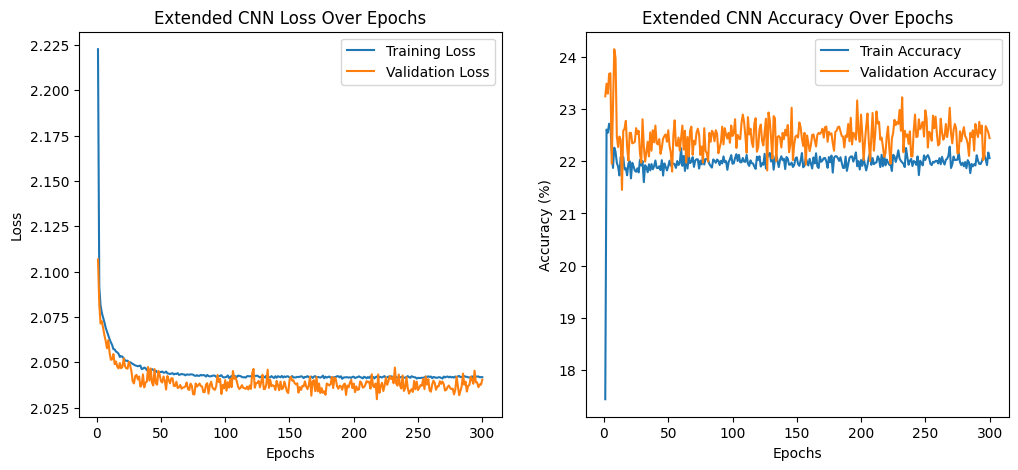


Classification Report:
              precision    recall  f1-score   support

           0     0.2078    0.2860    0.2407      1000
           1     0.1050    0.0210    0.0350      1000
           2     0.1379    0.0040    0.0078      1000
           3     0.1978    0.0540    0.0848      1000
           4     0.1515    0.0400    0.0633      1000
           5     0.2110    0.0230    0.0415      1000
           6     0.2124    0.7750    0.3335      1000
           7     0.2847    0.3670    0.3207      1000
           8     0.2430    0.4280    0.3100      1000
           9     0.2341    0.2460    0.2399      1000

    accuracy                         0.2244     10000
   macro avg     0.1985    0.2244    0.1677     10000
weighted avg     0.1985    0.2244    0.1677     10000



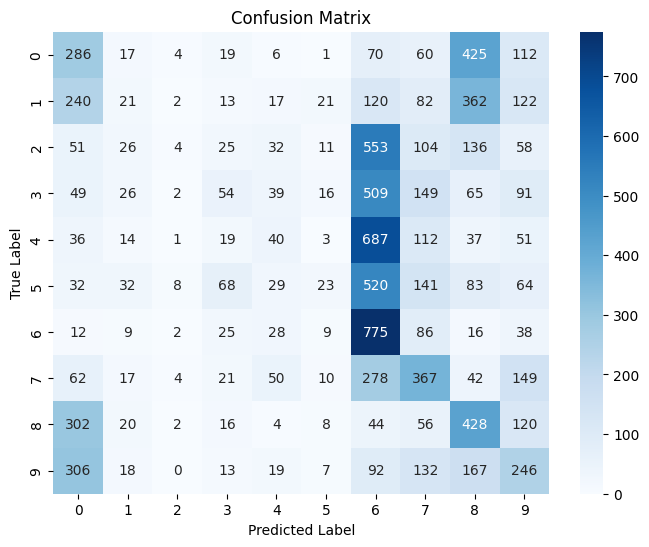

========== COMPARISON ==========


NameError: name 'cnn_params' is not defined

In [3]:
class ExtendedNetWidthCIFAR10(nn.Module):
    """
    1.b: NetWidth extended with ONE extra conv + tanh + max-pool.

    Shape flow:
    - Input:      (B, 3, 32, 32)
    - After conv1 + pool: (B, 32, 16, 16)
    - After conv2 + pool: (B, 16,  8,  8)
    - After conv3 + pool: (B, 16,  4,  4)
    - Flatten:    16 * 4 * 4 = 256 -> fc1(256 -> 32) -> fc2(32 -> 10)
    """
    def __init__(self, num_classes=10):
        super(ExtendedNetWidthCIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)  # neww layer

        self.fc1 = nn.Linear(16 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 16 * 4 * 4)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

extended_cnn = ExtendedNetWidthCIFAR10(num_classes=10).to(device)
extended_cnn_optimizer = optim.Adam(extended_cnn.parameters(), lr=0.0001, weight_decay=1e-1)

extended_cnn_params = count_parameters(extended_cnn)
print(f"[Extended CNN] Trainable parameters: {extended_cnn_params:,}")
print(f"[Extended CNN] Approx model size: {extended_cnn_params*4/1e6:.2f} MB (float32)")

EPOCHS_EXT = 300

start_time_ext = time.time()
ext_train_losses, ext_val_losses, ext_train_accs, ext_val_accs = train_model(
    extended_cnn,
    train_loader,
    test_loader,
    epochs=EPOCHS_EXT,
    pth_path="extended_cnn_CIFAR10_300epochs.pth",
    optimizer=extended_cnn_optimizer
)
ext_train_time = time.time() - start_time_ext

print("=" * 70)
print(f"[Extended CNN] Training time for {EPOCHS_EXT} epochs: {ext_train_time/60:.2f} minutes")
print(f"[Extended CNN] Final train loss: {ext_train_losses[-1]:.4f}")
print(f"[Extended CNN] Final val accuracy: {ext_val_accs[-1]:.2f}%")
plot_results(
    ext_train_losses,
    ext_train_accs,
    ext_val_losses,
    ext_val_accs,
    title_prefix="Extended CNN"
)

classification_metrics(extended_cnn, test_loader)

print("-------------------------------")
print(f"[Extended CNN] params        : {extended_cnn_params:,}")
print(f"[Extended CNN] final val acc: {ext_val_accs[-1]:.2f}%")
print(f"[Extended CNN] train time   : {ext_train_time/60:.2f} minutes ({EPOCHS_EXT} epochs)")
print("================================")


In [4]:
import time
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
class BasicBlock(nn.Module):
    """
    A simple 2-conv residual block:
    x -> Conv3x3 -> ReLU -> Conv3x3 -> (optionally downsample shortcut) + x -> ReLU
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int = 1,
                 use_bn: bool = False,
                 dropout_p: float = 0.0):
        super().__init__()

        bias = not use_bn

        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, stride=stride, padding=1, bias=bias))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout_p > 0.0:
            layers.append(nn.Dropout2d(dropout_p))

        layers.append(nn.Conv2d(out_channels, out_channels,
                                kernel_size=3, stride=1, padding=1, bias=bias))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))

        self.block = nn.Sequential(*layers)
        if stride != 1 or in_channels != out_channels:
            proj = [nn.Conv2d(in_channels, out_channels,
                              kernel_size=1, stride=stride, bias=False)]
            if use_bn:
                proj.append(nn.BatchNorm2d(out_channels))
            self.shortcut = nn.Sequential(*proj)
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.block(x)
        out = out + self.shortcut(x)
        out = self.relu(out)
        return out
class ResNet10CIFAR(nn.Module):
    """
    10 residual blocks total:

    - Stem conv (3x3, C=32)
    - Stage 1: 3 blocks, C=32
    - Stage 2: 3 blocks, C=64 (first block stride=2)
    - Stage 3: 4 blocks, C=128 (first block stride=2)
    - Global average pooling + linear 128 -> 10

    That’s 3 + 3 + 4 = 10 residual blocks.
    """
    def __init__(self,
                 num_classes: int = 10,
                 base_channels: int = 32,
                 use_bn: bool = False,
                 dropout_p: float = 0.0):
        super().__init__()

        self.use_bn = use_bn
        self.dropout_p = dropout_p

        bias = not use_bn
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(base_channels) if use_bn else nn.Identity(),
            nn.ReLU(inplace=True)
        )

        self.layer1 = self._make_layer(base_channels, base_channels, num_blocks=3, stride=1)

        self.layer2 = self._make_layer(base_channels, base_channels * 2, num_blocks=3, stride=2)

        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, num_blocks=4, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels * 4, num_classes)

    def _make_layer(self,
                    in_channels: int,
                    out_channels: int,
                    num_blocks: int,
                    stride: int) -> nn.Sequential:
        layers = []
        layers.append(
            BasicBlock(in_channels, out_channels, stride=stride,
                       use_bn=self.use_bn, dropout_p=self.dropout_p)
        )
        for _ in range(1, num_blocks):
            layers.append(
                BasicBlock(out_channels, out_channels, stride=1,
                           use_bn=self.use_bn, dropout_p=self.dropout_p)
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_loaders(batch_size: int = 128) -> tuple[DataLoader, DataLoader]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    trainset = datasets.CIFAR10(root="./data", train=True,
                                download=True, transform=transform_train)
    testset = datasets.CIFAR10(root="./data", train=False,
                               download=True, transform=transform_test)

    train_loader = DataLoader(trainset, batch_size=batch_size,
                              shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(testset, batch_size=batch_size,
                             shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader


def train_one_setting(
    setting_name: str,
    *,
    num_epochs: int = 300,
    lr: float = 0.1,
    weight_decay: float = 0.0,
    use_bn: bool = False,
    dropout_p: float = 0.0,
    batch_size: int = 128,
    device: str | torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    print(f"\n==== Training setting: {setting_name} ====")
    print(f"device: {device}, weight_decay={weight_decay}, use_bn={use_bn}, dropout_p={dropout_p}")

    train_loader, test_loader = get_loaders(batch_size=batch_size)

    model = ResNet10CIFAR(use_bn=use_bn, dropout_p=dropout_p).to(device)
    print(f"Total trainable parameters: {count_parameters(model):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=weight_decay,
    )
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[int(num_epochs * 0.5), int(num_epochs * 0.75)],
        gamma=0.1,
    )

    start_time = time.perf_counter()
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)

        if epoch % 50 == 0 or epoch == 1 or epoch == num_epochs:
            test_acc = evaluate(model, test_loader, device)
            print(f"Epoch {epoch:3d}/{num_epochs}: "
                  f"train_loss={epoch_loss:.4f}, test_acc={test_acc:.4f}")

    end_time = time.perf_counter()
    total_time = end_time - start_time

    final_train_loss = epoch_loss
    final_test_acc = evaluate(model, test_loader, device)

    print(f"\n---- {setting_name} FINAL RESULTS ----")
    print(f"Training time (s): {total_time:.2f}")
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Final test accuracy: {final_test_acc:.4f}")

    return total_time, final_train_loss, final_test_acc, count_parameters(model)


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device) -> float:
    model.eval()
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
    return correct / total


if __name__ == "__main__":
    train_one_setting(
        "Baseline ResNet-10",
        num_epochs=300,
        weight_decay=0.0,
        use_bn=False,
        dropout_p=0.0,
    ) train_one_setting(
        "Weight Decay λ=0.001",
        num_epochs=300,
        weight_decay=1e-3,
        use_bn=False,
        dropout_p=0.0,
    )

    train_one_setting(
        "Dropout p=0.3",
        num_epochs=300,
        weight_decay=0.0,
        use_bn=False,
        dropout_p=0.3,
    )

    train_one_setting(
        "BatchNorm",
        num_epochs=300,
        weight_decay=0.0,
        use_bn=True,
        dropout_p=0.0,
    )



==== Training setting: Baseline ResNet-10 ====
device: cuda, weight_decay=0.0, use_bn=False, dropout_p=0.0
Total trainable parameters: 1,377,994
Epoch   1/300: train_loss=1.8904, test_acc=0.3501
Epoch  50/300: train_loss=0.7010, test_acc=0.7511
Epoch 100/300: train_loss=2.3046, test_acc=0.1000
Epoch 150/300: train_loss=2.3046, test_acc=0.1000
Epoch 200/300: train_loss=2.3028, test_acc=0.1000
Epoch 250/300: train_loss=2.3026, test_acc=0.1000
Epoch 300/300: train_loss=2.3026, test_acc=0.1000

---- Baseline ResNet-10 FINAL RESULTS ----
Training time (s): 7489.28
Final training loss: 2.3026
Final test accuracy: 0.1000

==== Training setting: Weight Decay λ=0.001 ====
device: cuda, weight_decay=0.001, use_bn=False, dropout_p=0.0
Total trainable parameters: 1,377,994
Epoch   1/300: train_loss=2.0682, test_acc=0.3060
Epoch  50/300: train_loss=0.5921, test_acc=0.8053
Epoch 100/300: train_loss=0.5785, test_acc=0.8037
Epoch 150/300: train_loss=0.5665, test_acc=0.7981
Epoch 200/300: train_loss=0